In [38]:
# set automitic module reload. Useful when you are editing external python files
%load_ext autoreload   
%autoreload 2

%pylab inline

from lib.KDTreeEncoding import *

import xgboost as xgb
from lib.XGBHelper import *
from lib.XGBoost_params import *
from lib.score_analysis import *

from lib.logger import logger

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from numpy import load
from glob import glob
import pandas as pd
import pickle as pkl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


###  load image filenames

In [39]:
poverty_dir='/Users/yoavfreund/datasets/poverty_v1.1/'
#use the following line when running on datahub
#poverty_dir = '/dsmlp/datasets/cs255-sp22-a00-public/poverty/'
depth=8   #for KDTree

In [40]:
## load file list
image_dir=poverty_dir+'/anon_images'
files=[]
files+=glob(f'{image_dir}/*.npz')
len(files)

19669

In [41]:
!ls ../public_tables/

country_test_reduct.csv random_test_reduct.csv  train.csv


In [56]:
#load table entries
train_table='../public_tables/train.csv'
!ls -l $train_table

df=pd.read_csv(train_table,index_col=0)
df.index=df['filename']
df.shape

-rw-r--r--  1 yoavfreund  wheel  786422 May 23 16:59 ../public_tables/train.csv


(11365, 6)

In [51]:
#List the number of rows for each country, countries 0-4 are missing - the are in the country_test set
from collections import Counter
C=Counter(df['country'])
[(k,C[k]) for k in sorted(C)]

[(5, 676),
 (6, 641),
 (7, 329),
 (8, 586),
 (9, 1381),
 (10, 374),
 (11, 575),
 (12, 428),
 (13, 1068),
 (14, 581),
 (15, 756),
 (16, 248),
 (17, 246),
 (18, 581),
 (19, 424),
 (20, 456),
 (21, 543),
 (22, 1472)]

## train color encoder

Creates a KDtree in color space

In [9]:
%%time
## Generate encoding tree
train_size,tree=train_encoder(files,max_images=500,tree_depth=8)

used 500 images to train KDTree
KDTree training data shape= (25088000, 8)
CPU times: user 8.11 s, sys: 829 ms, total: 8.94 s
Wall time: 9.32 s


In [10]:
%%time
## Encode all data using encoding tree
Enc_data=encoded_dataset(image_dir,df,tree,label_col='label')

CPU times: user 2min 30s, sys: 23.5 s, total: 2min 54s
Wall time: 3min 3s


In [11]:
Enc_data.data.shape

(11365, 513)

In [12]:

D=DataSplitter(Enc_data.data)

### Train and test

In [13]:
# set parameters for XGBoost
param['max_depth']=2
param['num_round']=10
param

{'max_depth': 2,
 'eta': 0.3,
 'verbosity': 0,
 'objective': 'binary:logistic',
 'nthread': 7,
 'eval_metric': ['error', 'logloss'],
 'num_round': 10}

### Train on random split, urban and rural together

-rw-r--r--  1 yoavfreund  staff  4834108 May 24 13:48 data/DumpNoSplit.pk
CPU times: user 2min 15s, sys: 2.26 s, total: 2min 17s
Wall time: 24 s


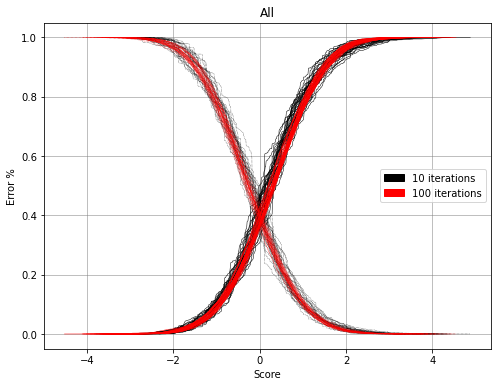

In [29]:
%%time
train_selector=np.random.rand(df.shape[0]) > 0.7
Train=D.get_subset(train_selector)
Test=D.get_subset(~train_selector)

param['num_round']=10
log10=simple_bootstrap(Train,Test,param,ensemble_size=30)
param['num_round']=100
log100=simple_bootstrap(Train,Test,param,ensemble_size=30)

styled_logs=[
    {   'log':log10,
        'style':['k:','k-'],
        'label':'10 iterations',
        'label_color':'k'
    },
    {   'log':log100,
        'style':['r:','r-'],
        'label':'100 iterations',
        'label_color':'r'
    }
]
_mean,_std=plot_scores(styled_logs,title='All')

pickle_file=f'data/DumpNoSplit.pk'
Dump={'styled_logs':styled_logs,
     'tree':tree,
     'mean':_mean,
     'std':_std}
pkl.dump(Dump,open(pickle_file,'wb'))
!ls -l $pickle_file

## Train on Urban only
Random split into train and test.

-rw-r--r--  1 yoavfreund  staff  3590047 May 24 22:00 data/DumpUrban.pk
CPU times: user 1min, sys: 4.14 s, total: 1min 4s
Wall time: 11.2 s


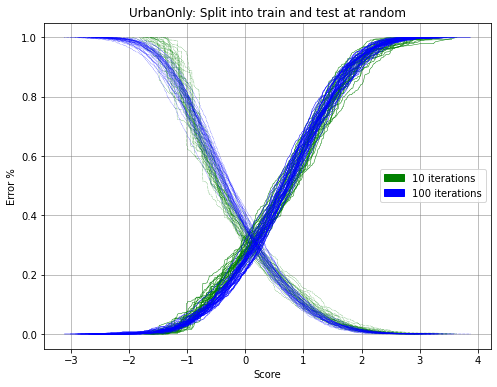

In [47]:
%%time
urban=True
area= 'Urban' if urban else 'Rural'
selector=df['urban']==urban
subData=D.get_subset(selector)
subD=DataSplitter(subData)

train_selector=np.random.rand(subData.shape[0]) > 0.7
Train=subD.get_subset(train_selector)
Test=subD.get_subset(~train_selector)

param['num_round']=10
log10=simple_bootstrap(Train,Test,param,ensemble_size=30)
param['num_round']=100
log100=simple_bootstrap(Train,Test,param,ensemble_size=30)

styled_logs=[
    {   'log':log10,
        'style':['g:','g-'],
        'label':'10 iterations',
        'label_color':'g'
    },
    {   'log':log100,
        'style':['b:','b-'],
        'label':'100 iterations',
        'label_color':'b'
    }
]

_mean,_std=plot_scores(styled_logs,title=f'{area}Only: Split into train and test at random')

pickle_file=f'data/Dump{area}.pk'
Dump={'styled_logs':styled_logs,
     'tree':tree,
     'mean':_mean,
     'std':_std}
pkl.dump(Dump,open(pickle_file,'wb'))
!ls -l $pickle_file

## Train on Rural only
Random split into train and test.

-rw-r--r--  1 yoavfreund  staff  4105832 May 24 10:30 data/DumpRural.pk


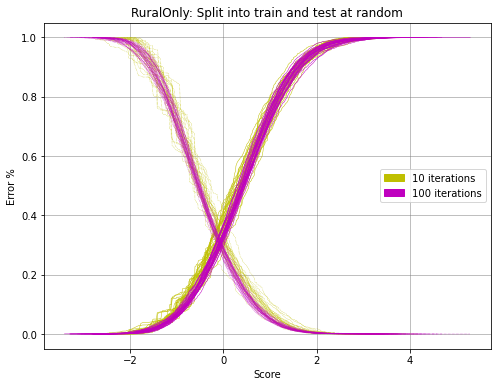

In [28]:
urban=False
area= 'Urban' if urban else 'Rural'
selector=df['urban']==urban
subData=D.get_subset(selector)
subD=DataSplitter(subData)

train_selector=np.random.rand(subData.shape[0]) > 0.7
Train=subD.get_subset(train_selector)
Test=subD.get_subset(~train_selector)

param['num_round']=10
log10=simple_bootstrap(Train,Test,param,ensemble_size=30)
param['num_round']=100
log100=simple_bootstrap(Train,Test,param,ensemble_size=30)

styled_logs=[
    {   'log':log10,
        'style':['y:','y-'],
        'label':'10 iterations',
        'label_color':'y'
    },
    {   'log':log100,
        'style':['m:','m-'],
        'label':'100 iterations',
        'label_color':'m'
    }
]

_mean,_std=plot_scores(styled_logs,title=f'{area}Only: Split into train and test at random')

pickle_file=f'data/Dump{area}.pk'
Dump={'styled_logs':styled_logs,
     'tree':tree,
     'mean':_mean,
     'std':_std}
pkl.dump(Dump,open(pickle_file,'wb'))
!ls -l $pickle_file